In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import re
import pynlpir
pynlpir.open()
from sklearn import metrics

from helpers import *
from generate import *
from diagnostic import *

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

### Import model

In [2]:
model = torch.load('models/linux_3x512_0d3_gru_200l_40000E.model').cuda()
print('Perplexity:', 2**np.mean([test_model(model, 'data/linux/test.txt') for _ in range(1)]))

Perplexity: 2.28175041097


### Generate text

In [3]:
text, hiddens = generate(model, '\n\n', 500, 0.8, True, output_hiddens=True)
print(text)

	/* complete to support driver node extensed by the new probe for bnet/evential
	 * and the new reference of the group with the request.
	 */
	for (i = 0; i < qla844x_init_locked_mode(adapter->msg[i]);

	return 0;
}

static int acpi_device_destroy(struct device *dev)
{
	struct i40iw_file *filp = to_video_device(&pdev->dev);
	int lookup_config;
	int err;
	enum wnic_adapter_type type;
	pipe_ctl = of_clk_handler(idev);

	il_close(list);
	return 0;
}

static int module_initcall(struct snd_kcontrol *


### Define Code Hypotheses

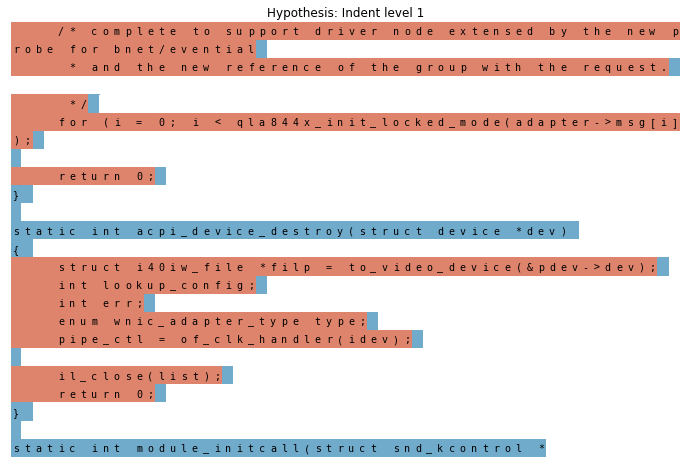

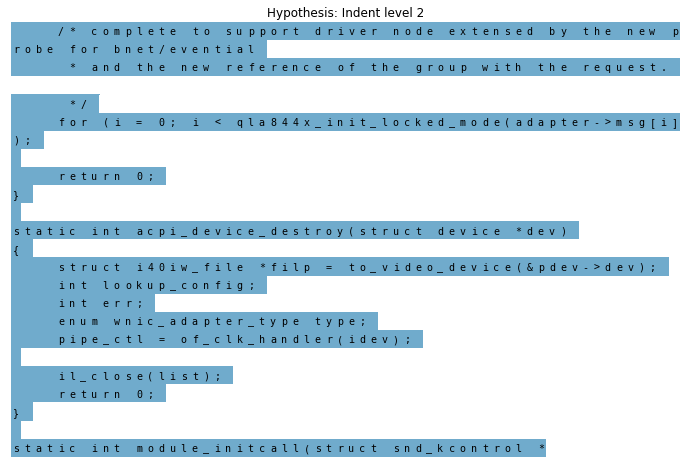

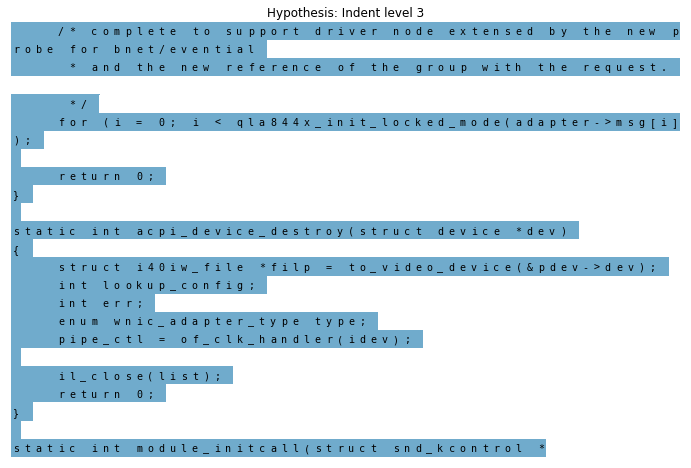

In [9]:
def hypothesis_inlinecounter(text):
    hyp = np.concatenate([np.linspace(1, -1, len(x)+1) for x in text.split('\n')])[:-1]
    return hyp

def hypothesis_comments(text):
    hyp = np.full(len(text), -1)
    in_brac_comment = False
    in_line_comment = False
    for i in range(len(text)):
        if text[i:i+2] == '//':
            in_line_comment = True
        elif text[i] == '\n':
            in_line_comment = False
        elif text[i:i+2] == '/*':
            in_brac_comment = True
        elif text[i:i+2] == '*/':
            in_brac_comment = False
        if in_brac_comment:
            hyp[i:i+3] = 1
        if in_line_comment:
            hyp[i:i+1] = 1
    return hyp

def hypothesis_indentation(text, level):
    hyp = np.full(len(text), -1)
    cur_level = 0
    for i, char in enumerate(text):
        if char == '\n':
            cur_level = 0
        elif char == '\t':
            cur_level += 1
        if cur_level >= level:
            hyp[i] = 1
    return hyp
    
# plot_colored_text(text, hypothesis_comments(text), title='Hypothesis: Comments', save_file='plots/hyp_comments.png')
plot_colored_text(text, hypothesis_indentation(text, 1), title='Hypothesis: Indent level 1', save_file='plots/hyp_indent_1.png')
plot_colored_text(text, hypothesis_indentation(text, 2), title='Hypothesis: Indent level 2', save_file='plots/hyp_indent_2.png')
plot_colored_text(text, hypothesis_indentation(text, 3), title='Hypothesis: Indent level 3', save_file='plots/hyp_indent_3.png')

y_true, y_pred = validate_hypothesis(model, LogisticRegression(class_weight='balanced'), lambda x: hypothesis_indentation(x, 1), train_len=50, test_len=10)
print('acc:      ', metrics.accuracy_score(y_true, y_pred))
print('prec:     ', metrics.precision_score(y_true, y_pred))
print('recall:   ', metrics.recall_score(y_true, y_pred))
print('f1-score: ', metrics.f1_score(y_true, y_pred))
y_true, y_pred = validate_hypothesis(model, LogisticRegression(class_weight='balanced'), hypothesis_comments, train_len=50, test_len=10)
print('acc:      ', metrics.accuracy_score(y_true, y_pred))
print('prec:     ', metrics.precision_score(y_true, y_pred))
print('recall:   ', metrics.recall_score(y_true, y_pred))
print('f1-score: ', metrics.f1_score(y_true, y_pred))
y_true, y_pred = validate_hypothesis(model, LogisticRegression(), lambda x: hypothesis_indentation(x, 1), train_len=50, test_len=10)
print('acc:      ', metrics.accuracy_score(y_true, y_pred))
print('prec:     ', metrics.precision_score(y_true, y_pred))
print('recall:   ', metrics.recall_score(y_true, y_pred))
print('f1-score: ', metrics.f1_score(y_true, y_pred))
y_true, y_pred = validate_hypothesis(model, LogisticRegression(), hypothesis_comments, train_len=50, test_len=10)
print('acc:      ', metrics.accuracy_score(y_true, y_pred))
print('prec:     ', metrics.precision_score(y_true, y_pred))
print('recall:   ', metrics.recall_score(y_true, y_pred))
print('f1-score: ', metrics.f1_score(y_true, y_pred))

# Analysis on Shakespeare model 

### Load Shakespeare language odel

In [ ]:
model = torch.load('models/simple.model').cuda()
print('Perplexity:', 2**np.mean([test_model(model, 'data/tiny-shakespeare/test.txt') for _ in range(1)]))

### Generate text

In [ ]:
text, hiddens = generate(model, '\n\n', 500, 0.8, True, output_hiddens=True)
print(text)

### Define language hypotheses

In [ ]:
def hypothesis_inlinecounter(text):
    hyp = np.concatenate([np.linspace(1, -1, len(x)+1) for x in text.split('\n')])[:-1]
    return hyp

def hypothesis_capswords(text):
    hyp = np.concatenate([np.full(len(x)+1, 1) if re.sub('[^a-zA-Z]+', '', x).isupper() else np.full(len(x)+1, -1) for x in text.split('\n')])[:-1]
    return hyp

def hypothesis_pos(text, pos_tag):
    hyp = text.replace('1', '0')
    for word, tag in pynlpir.segment(text):
        if tag == pos_tag:
            hyp = hyp.replace(word, '1'*len(word), 1)
        else:
            hyp = hyp.replace(word, '0'*len(word), 1)
    hyp = [1 if x=='1' else -1 for x in re.sub('[^1]', '0', hyp)]
    
    return hyp

def hypothesis_verbs(text):
    return hypothesis_pos(text, 'verb')

def hypothesis_nouns(text):
    return hypothesis_pos(text, 'noun')

In [ ]:
plot_colored_text(text, hypothesis_inlinecounter(text), title='Hypothesis: Inline Counter', save_file='plots/hyp_inlinecounter.png')
plot_colored_text(text, hypothesis_capswords(text), title='Hypothesis: Capitalized Words', save_file='plots/hyp_capswords.png')
plot_colored_text(text, hypothesis_verbs(text), title='Hypothesis: Verbs', save_file='plots/hyp_verbs')
plot_colored_text(text, hypothesis_nouns(text), title='Hypothesis: Nouns', save_file='plots/hyp_nouns')

In [ ]:
y_true, y_pred = validate_hypothesis(model, LinearRegression(), hypothesis_inlinecounter)
y_true, y_pred = validate_hypothesis(model, LogisticRegression(), hypothesis_capswords)
print('acc:      ', metrics.accuracy_score(y_true, y_pred))
print('prec:     ', metrics.precision_score(y_true, y_pred))
print('recall:   ', metrics.recall_score(y_true, y_pred))
print('f1-score: ', metrics.f1_score(y_true, y_pred))

In [ ]:
y_true, y_pred = validate_hypothesis(model, LogisticRegression(), hypothesis_nouns)
print('acc:      ', metrics.accuracy_score(y_true, y_pred))
print('prec:     ', metrics.precision_score(y_true, y_pred))
print('recall:   ', metrics.recall_score(y_true, y_pred))
print('f1-score: ', metrics.f1_score(y_true, y_pred))


In [ ]:
y_true, y_pred = validate_hypothesis(model, LogisticRegression(), hypothesis_verbs)
print('acc:      ', metrics.accuracy_score(y_true, y_pred))
print('prec:     ', metrics.precision_score(y_true, y_pred))
print('recall:   ', metrics.recall_score(y_true, y_pred))
print('f1-score: ', metrics.f1_score(y_true, y_pred))